In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from pyslingshot import Slingshot

/Users/jacob/proj/pyslingshot/pyslingshot/slingshot.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


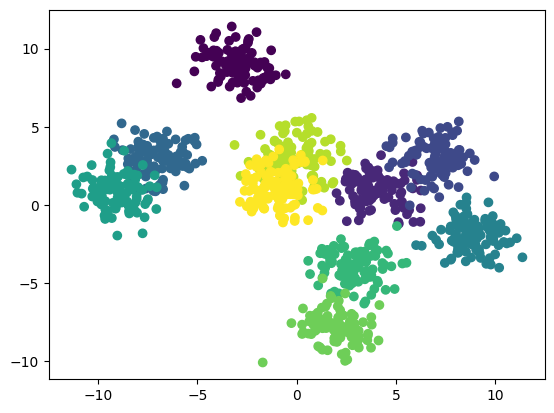

In [2]:
load = True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10  # cluster labels
if num_branches == 2:
    filename = "fakedata-2branch.npy"
    start_node = 5
else:
    filename = "fakedata-1branch.npy"
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data["cluster_labels"]
    data = data["data"]
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = np.random.randint(20, 2) - 10
        print(offset.shape)

        data.append(offset + np.random.randn(num_cells // K, num_dims_reduced))
        cluster_labels[k * cells : (k + 1) * cells] = k
    data = np.concatenate(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

## Convert data into AnnData object [optional]

In [3]:
from anndata import AnnData

num_cells = 1000
num_genes = 500
ad = AnnData(np.zeros((num_cells, num_genes)))
ad.obsm["X_umap"] = data
ad.obs["celltype"] = cluster_labels
ad

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'celltype'
    obsm: 'X_umap'

/Users/jacob/proj/pyslingshot/pyslingshot/util.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x30fca0c90>, <pcurvepy2.pcurve.PrincipalCurve object at 0x319c2a350>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x173ecda90>, <pcurvepy2.pcurve.PrincipalCurve object at 0x3188fca50>]
Shrinking branch @8 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x173ecda90>, <pcurvepy2.pcurve.PrincipalCurve object at 0x3188fca50>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x30fca0c90>, <pcurvepy2.pcurve.PrincipalCurve object at 0x319c2a350>]


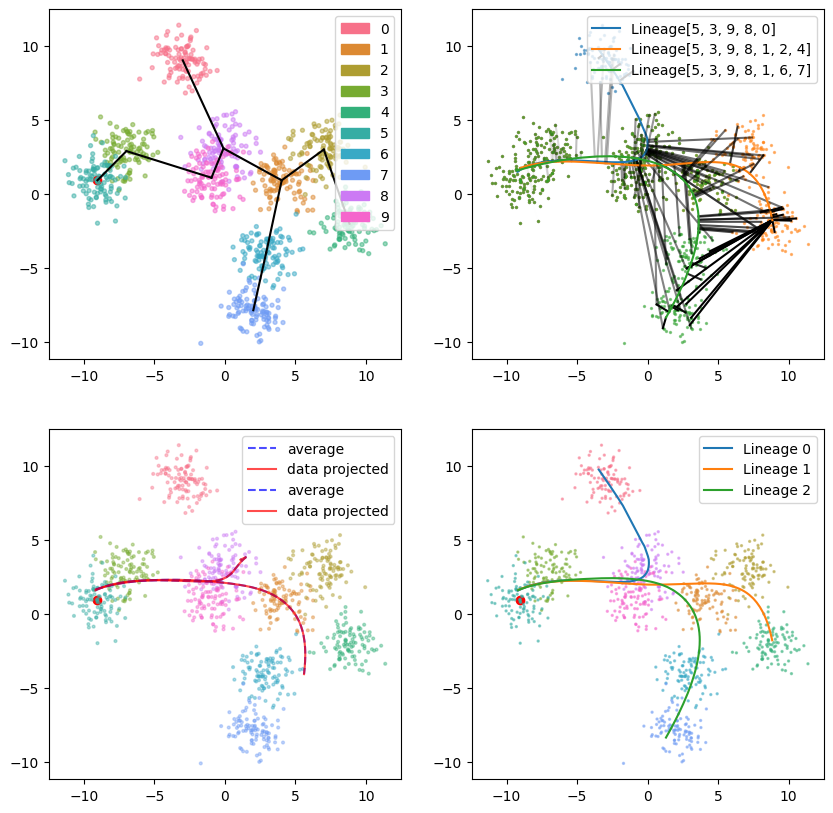

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(ad, celltype_key="celltype", obsm_key="X_umap", start_node=start_node, is_debugging="verbose")

slingshot.fit(num_epochs=1, debug_axes=axes)

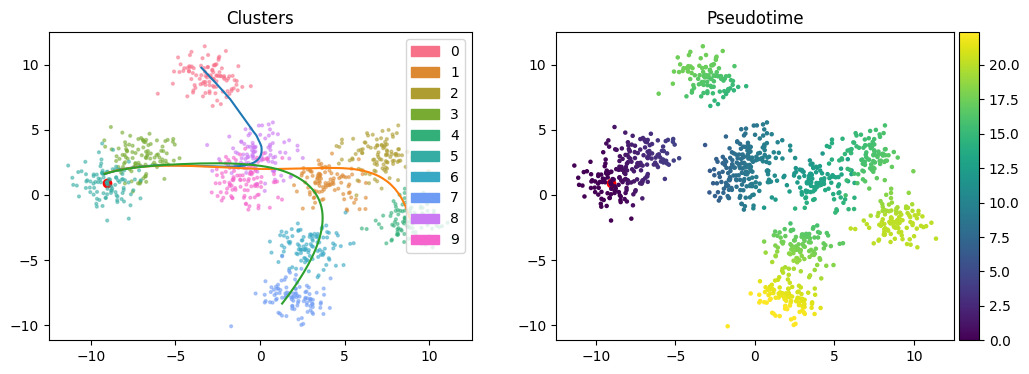

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title("Clusters")
axes[1].set_title("Pseudotime")
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode="pseudotime", s=5)

# Get Pseudotime

In [6]:
# NOTE: the Slingshot class has a property which has the pseudotime that is used to
# color the plot above
pseudotime = slingshot.unified_pseudotime